<a href="https://colab.research.google.com/github/rdemarqui/studies/blob/master/ChatGPT_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importa os módulos necessários
import os, time
import pandas as pd

try:
  import openai
except:
  !pip install -q openai==0.28.1 cohere tiktoken
  import openai

In [ ]:
# Configura a pasta raíz
root = os.getcwd()
print(root)

Configure uma chave em: https://platform.openai.com/api-keys

In [ ]:
# Configura a chave para acessar a API
KEY=""
openai.api_key = KEY

In [ ]:
# Abre o arquivo com os dados do NPS
columns = ["respondent_id", "date_created", "p1b_motivo_detrator", "p1b_motivo_detrator_aberto"]
df_full = pd.read_excel("sample_data/data_usodados_detratores_set_out.xlsx", usecols=columns)

df = df_full.query("p1b_motivo_detrator == 'Outro motivo. Qual?'")    # Filtra motivo
df = df.query("p1b_motivo_detrator_aberto.str.len() > 3")    # Filtra quantidade de caracteres
print(f"\nTamanho do conjunto de dados{df.shape}\n")
df.head()

Por se tratar de free tier, a OpenAI limita a quantidade de requisições que podem ser feitas, como 3 requisições por minuto e 200 requisições por dia, conforme tabela abaixo.

fonte: https://platform.openai.com/docs/guides/rate-limits/usage-tiers?context=tier-free

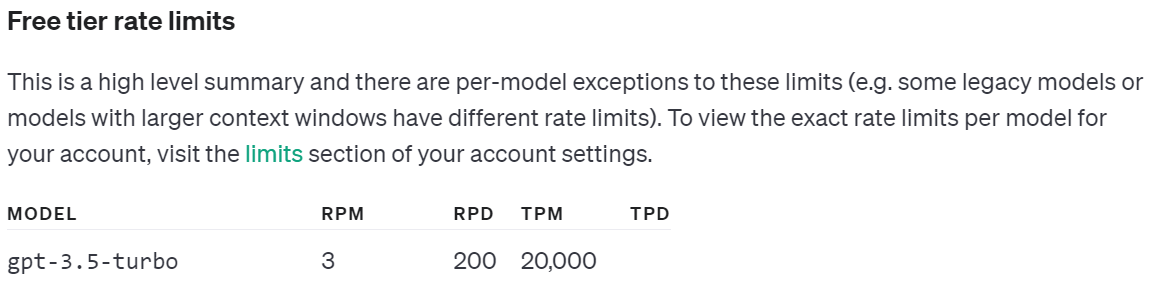

In [ ]:
# Tempo de uso
200/3

## Few-Shot Learning

Vamos utilizar a técnica de prompt engeneering chamada few-shot learning, onde damos alguns exemplos ao algoritmo para que ele possa enteder o padrão e replicá-lo em suas respostas.

In [ ]:
# Configurações de prompt
prompt = """
Classifique a avaliação do usuário em uma das categorias abaixo:
roaming; cobrança indevida; recarga/fatura; mensagens exaustivas, atendimento, beneficio insuficiente, preço, conexão/cobertura, não justificado.

Avaliação: {avaliacao}"""

examples = [
    {"input": "Cobertura ruim e custo benefício do plano cara.", "output": "conexão/cobertura, beneficio insuficiente, preço"},
    {"input": "Além da Internet lenta e instável, muitas mensagens publicitárias de uma empresa que nos já contratamos, não faz sentido nenhum!", "output": "conexão/cobertura, mensagens exaustivas"}
]

In [ ]:
def gpt_analysis(user_aval):
  response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
          {"role": "system", "content": "Analista de reclamações"},

          {"role": "user", "content": prompt.format(avaliacao=examples[0]["input"])},
          {"role": "assistant", "content": examples[0]["output"]},
          {"role": "user", "content": prompt.format(avaliacao=examples[1]["input"])},
          {"role": "assistant", "content": examples[1]["output"]},

          {"role": "user", "content": prompt.format(avaliacao=user_aval)}
    ]
  )
  return response['choices'][0]['message']['content']

In [ ]:
# Testando a função
teste = "Além de caro uma porcaria de vcs essa internet"
gpt_analysis(teste)

In [ ]:
def apply_classifier_to_range(df, start_row, end_row, rpm):
    # Garante que o intervalo está dentro dos limites do DataFrame
    start_row = max(0, start_row)
    end_row = min(end_row, len(df))

    # Calcula o tempo de espera entre as iterações
    wait_time = (60 / rpm) + 5

    # Itera sobre as linhas na faixa especificada
    for index, row in df.iloc[start_row:end_row + 1].iterrows():
        # Aplica a função de classificação à linha atual e atribui o resultado à coluna 'classificação'
        df.at[index, 'classificação'] = gpt_analysis(row)

        # Pausa o programa para controlar o número de iterações por minuto
        time.sleep(wait_time)

In [ ]:
apply_classifier_to_range(df=df, start_row=0, end_row=2, rpm=3)

In [ ]:
df.head()